# Naive Bayes classifier: Google Play Store reviews

## Notebook set-up

In [1]:

# Python standard library imports
import string
from pathlib import Path

# PyPI imports
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from scipy.stats import randint
from sklearn.cluster import FeatureAgglomeration
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB, CategoricalNB, ComplementNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

# Download natural language tooklkit resources
nltk.download('punkt_tab')
nltk.download('wordnet')

# Set random seed for reproducibility
RANDOM_SEED = 315

# Set cross-validation folds
CV_FOLDS = 3

[nltk_data] Downloading package punkt_tab to /home/vscode/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1. Data loading

### 1.1. Load data from URL

In [2]:
# Load the data from the URL provided in the project tutorial
data_df = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/naive-bayes-project-tutorial/main/playstore_reviews.csv')

### 1.2. Save a local copy

In [3]:
# Make a directory for raw data
Path('../data/raw').mkdir(exist_ok=True, parents=True)

# Save a local copy of the raw data
data_df.to_parquet('../data/raw/playstore_reviews.parquet')

### 1.3. Inspect

In [4]:
data_df.head()

,package_name,review,polarity
0,com.facebook.katana,privacy at least put some option appear offli...,0
1,com.facebook.katana,"messenger issues ever since the last update, ...",0
2,com.facebook.katana,profile any time my wife or anybody has more ...,0
3,com.facebook.katana,the new features suck for those of us who don...,0
4,com.facebook.katana,forced reload on uploading pic on replying co...,0


In [5]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   package_name  891 non-null    object
 1   review        891 non-null    object
 2   polarity      891 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 21.0+ KB


## 2. Review length distribution

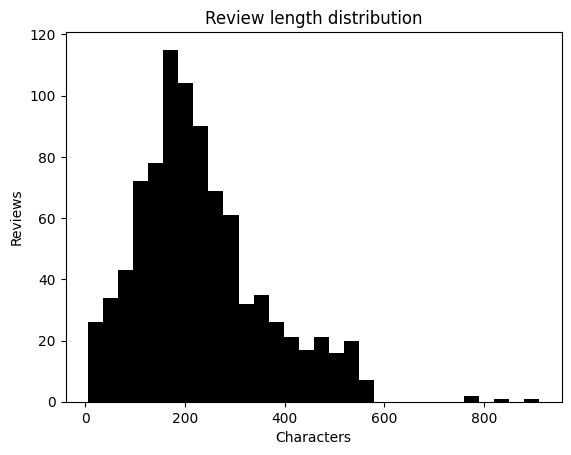

Review length mean: 232
Review length min: 6
Review length max: 910


In [6]:
lengths = data_df['review'].str.len().tolist()

plt.title('Review length distribution')
plt.xlabel('Characters')
plt.ylabel('Reviews')
plt.hist(lengths, bins=30, color='black')
plt.show()

print(f'Review length mean: {np.mean(lengths):.0f}')
print(f'Review length min: {min(lengths):.0f}')
print(f'Review length max: {max(lengths):.0f}')

### 2.1. Long reviews

In [7]:
data_df['review_length'] = lengths
long_reviews = data_df[data_df['review_length'] > 600]

print(long_reviews['review'].iloc[0])

 bait and switch i purchased my 3rd samsung tablet with  advertisement of free gifts, one of them being 48 additional gb cloud storage for 2 years.  the 2nd samsung tablet i bought also had this free gift and it was a nightmare to get samsung and dropbox to honor it.  so, after buying this 3rd high end tablet with the same claim of the free 48gb for 2 years in the fine print, which you can only see after purchasing the tablet, dropbox only honors the offer on the first device you purchased and you are disqualified for all future devices.  this is sleazy and bait and switch.  free= not subject to any compensation, encumbrance, repayment in kind, etc.  because of this bait and switch advertising on the part of samsung and dropbox i suggest you really find out what kind of company dropbox is before using their services.


In [8]:
print(long_reviews['review'].iloc[1])

  ătoo slow loading webclips!!! ăno pdf support at all... (even simpler apps do that!) ă web pages that are clipped do not adjust to current window size automatically when window is shrunk or expanded, (any program does this...geez). ă highlighting? needs more colors instead of brown mustard yellow. no customer support responses either, evernote must have been taken over by students. it's not even fun to use anymore because it is slow as hell.  this is especially for serious business users. any five star ratings down here must have been given by employees under different themes. this program has really retarded over the years. they need to stick to improving their bread and butter instead of selling side junk and features that are useless. well they got my money this time, so i have to put up with it for a few more months. the lack of pdf support really is terrible for a program like this.


In [9]:
print(long_reviews['review'].iloc[2])

  not since the update i don't.                                  update:- it is very slow on both data (uk ee network) and wifi (all of home via bt /work network/london underground virgin network) on all devices. version number is 13.0.2036.98649 on each device.  practically unusable at present and everything was fine before upgrading.  reading other comments i'm far from the only one having problems. high and low quality images helps but it is still worse than before the upgrade.  and just discovered that previously a double tap enlarged the text sufficiently to make it readable.  now it enlarges it a tiny amount but pinch and zoom is still required.    why did you do this?  the good old adage 'if it ain't broke don't fix it absolutely comes to mind.


### 2.2. Short reviews

In [10]:
short_length = 30

short_reviews = data_df[data_df['review_length'] < short_length]
short_reviews.head()

,package_name,review,polarity,review_length
511,com.Slack,love new material design,1,26
513,com.Slack,better than groupme đ,1,26
514,com.Slack,one account for all devices,1,29
557,jabanaki.todo.todoly,awesome,1,11
755,com.shirantech.kantipur,too much pop up add,0,21


### 2.3. Filter reviews by length

In [11]:
data_df = data_df[(data_df['review_length'] >= 10) & (data_df['review_length'] <= 600)]
data_df.reset_index(drop=True, inplace=True)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 885 entries, 0 to 884
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   package_name   885 non-null    object
 1   review         885 non-null    object
 2   polarity       885 non-null    int64 
 3   review_length  885 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 27.8+ KB


## 3. Text preprocessing

In [12]:
# Get just the reviews
reviews = data_df['review']

In [13]:
# Lowercase the reviews
reviews = reviews.str.lower()

In [14]:
# Remove numbers
reviews = reviews.str.replace(r'\d+', '', regex=True)

In [15]:
# Remove punctuation
reviews = reviews.str.replace('[{}]'.format(string.punctuation), '')

In [16]:
# Lemmatize the text

def lemmatize_text(text):

    # Create a lemmatizer object
    lemmatizer = WordNetLemmatizer()

    # Tokenize the text into words
    words = nltk.word_tokenize(text)

    # Lemmatize each word
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]

    # Join the lemmatized words back into a string
    lemmatized_text = ' '.join(lemmatized_words)

    return lemmatized_text

reviews = reviews.apply(lemmatize_text)

## 4. Bag-of-words encoding

### 4.1. Text vectorization

In [18]:
# Fit the count vectorizer and transform the reviews into word counts
vector_model = CountVectorizer(stop_words="english")
word_counts = vector_model.fit_transform(reviews).toarray()

print(f'Word count matrix has {word_counts.shape[0]} rows and {word_counts.shape[1]} columns')

# Get the words from the vector model
feature_names = vector_model.get_feature_names_out()

# Convert the word counts back into a dataframe
word_count_df = pd.DataFrame(word_counts, columns=feature_names)

# Take a look...
word_count_df.head()

Word count matrix has 885 rows and 3221 columns


,aafnaii,aakhirat,aalikati,aap,aaps,aapsssssss,aaru,ability,abke,able,...,šŕľ,ťŕ,ťŕľ,źŕ,żŕ,żŕľ,žŕ,žŕľ,ˇŕ,ˇŕľ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 4.2. Word count distribution

Word count min: 1
Word count max: 429


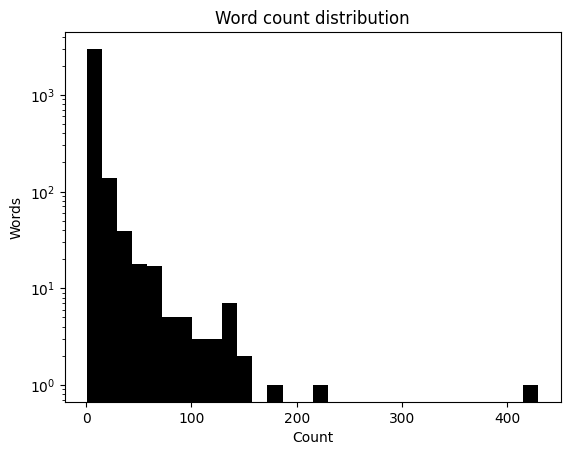

In [19]:
word_counts = word_count_df.sum().tolist()

print(f'Word count min: {min(word_counts)}')
print(f'Word count max: {max(word_counts)}')

plt.title('Word count distribution')
plt.xlabel('Count')
plt.ylabel('Words')
plt.hist(word_counts, bins=30, color='black')
plt.yscale('log')
plt.show()

### 4.3. Feature selection

In [20]:
total_word_count_df = pd.DataFrame({
    'word': word_count_df.columns,
    'count': word_counts
})

trimmed_word_count_df = total_word_count_df[(total_word_count_df['count'] > 3) & (total_word_count_df['count'] < 150)]

word_count_df = word_count_df[trimmed_word_count_df['word'].tolist()]
word_count_df.reset_index(drop=True, inplace=True)
word_count_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 885 entries, 0 to 884
Columns: 838 entries, ability to žŕľ
dtypes: int64(838)
memory usage: 5.7 MB


Word count min: 4
Word count max: 146


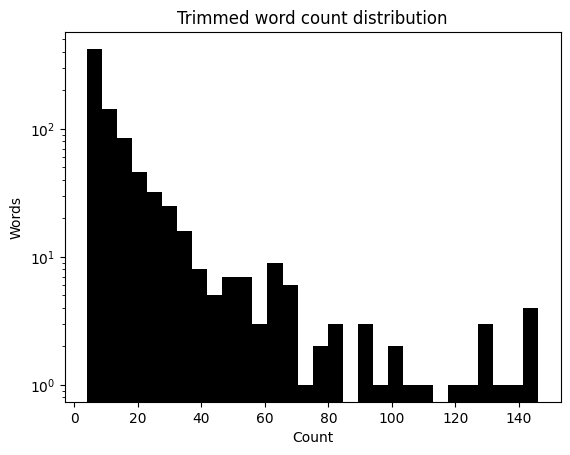

In [21]:
word_counts = word_count_df.sum().tolist()

print(f'Word count min: {min(word_counts)}')
print(f'Word count max: {max(word_counts)}')

plt.title('Trimmed word count distribution')
plt.xlabel('Count')
plt.ylabel('Words')
plt.hist(word_counts, bins=30, color='black')
plt.yscale('log')
plt.show()

## 5. Data preparation

In [22]:
# Add the label back
word_count_df['polarity'] = data_df['polarity'].copy()

# Train test split
training_df, testing_df = train_test_split(word_count_df, test_size=0.3)

## 6. Model comparison

In [23]:
cross_val_scores={
    'Model': [],
    'Score': []
}

### 6.1. Standard Scikit-learn implementations

In [ ]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=500, random_state=RANDOM_SEED),
    'MultinomialNB': MultinomialNB(random_state=RANDOM_SEED),
    'GaussianNB': GaussianNB(random_state=RANDOM_SEED),
    'BernoulliNB': BernoulliNB(random_state=RANDOM_SEED),
    'CategoricalNB': CategoricalNB(random_state=RANDOM_SEED),
    'ComplementNB': ComplementNB(random_state=RANDOM_SEED)
}

In [24]:
scores = cross_val_score(
    LogisticRegression(),
    training_df.drop('polarity', axis=1),
    training_df['polarity'],
    cv=CV_FOLDS,
    n_jobs=-1
)

cross_val_scores['Model'].extend(['Logistic regression']*len(scores))
cross_val_scores['Score'].extend(scores*100)

print(f'Cross-validation accuracy: {np.mean(scores)*100:.1f} +/- {np.std(scores)*100:.1f}%')

Cross-validation accuracy: 79.5 +/- 1.3%


### 6.2. Gaussian naive Bayes

In [25]:
scores = cross_val_score(
    GaussianNB(),
    training_df.drop('polarity', axis=1),
    training_df['polarity'],
    cv=CV_FOLDS,
    n_jobs=-1
)

cross_val_scores['Model'].extend(['GaussianNB']*len(scores))
cross_val_scores['Score'].extend(scores*100)

print(f'Cross-validation accuracy: {np.mean(scores)*100:.1f} +/- {np.std(scores)*100:.1f}%')

Cross-validation accuracy: 73.2 +/- 1.7%


### 6.3. Bernoulli naive Bayes

In [26]:
scores = cross_val_score(
    BernoulliNB(),
    training_df.drop('polarity', axis=1),
    training_df['polarity'],
    cv=CV_FOLDS,
    n_jobs=-1
)

cross_val_scores['Model'].extend(['BernoulliNB']*len(scores))
cross_val_scores['Score'].extend(scores*100)

print(f'Cross-validation accuracy: {np.mean(scores)*100:.1f} +/- {np.std(scores)*100:.1f}%')

Cross-validation accuracy: 78.3 +/- 2.3%


### 6.4. Multinomial naive Bayes

In [27]:
scores = cross_val_score(
    MultinomialNB(),
    training_df.drop('polarity', axis=1),
    training_df['polarity'],
    cv=CV_FOLDS,
    n_jobs=-1
)

cross_val_scores['Model'].extend(['MultinomialNB']*len(scores))
cross_val_scores['Score'].extend(scores*100)

print(f'Cross-validation accuracy: {np.mean(scores)*100:.1f} +/- {np.std(scores)*100:.1f}%')

Cross-validation accuracy: 79.5 +/- 2.1%


### 6.5. Complement naive Bayes

In [28]:
scores = cross_val_score(
    ComplementNB(),
    training_df.drop('polarity', axis=1),
    training_df['polarity'],
    cv=CV_FOLDS,
    n_jobs=-1
)

cross_val_scores['Model'].extend(['ComplementNB']*len(scores))
cross_val_scores['Score'].extend(scores*100)

print(f'Cross-validation accuracy: {np.mean(scores)*100:.1f} +/- {np.std(scores)*100:.1f}%')

Cross-validation accuracy: 79.5 +/- 1.0%


### 6.6. CategoricalNB

In [29]:
scores = cross_val_score(
    CategoricalNB(),
    training_df.drop('polarity', axis=1),
    training_df['polarity'],
    cv=CV_FOLDS,
    n_jobs=-1
)

cross_val_scores['Model'].extend(['CategoricalNB']*len(scores))
cross_val_scores['Score'].extend(scores*100)

print(f'Cross-validation accuracy: {np.mean(scores)*100:.1f} +/- {np.std(scores)*100:.1f}%')

Cross-validation accuracy: nan +/- nan%


/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 156, in __call__
    score = scorer(estimator, *args, **routed_params.get(name).score)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 492, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/base.py", line 548, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/naive_bayes.py", line 106, in 

### 6.5. Multinomial naive Bayes + PCA

#### 6.5.1. Component number

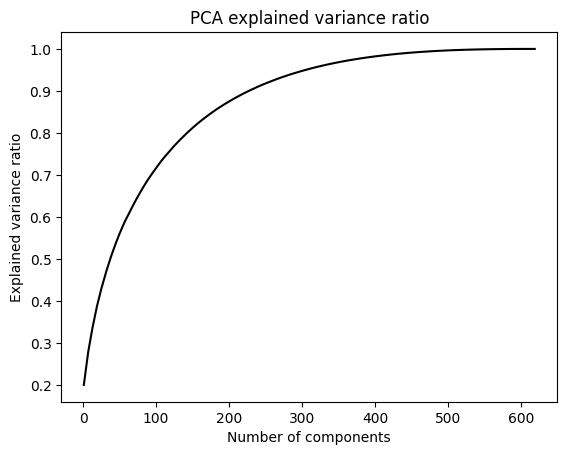

In [37]:
components_list = np.linspace(1, training_df.shape[0], 100, dtype=int)

n_components = []
variance = []

for components in components_list:
    print(f'Calculating {components} components...', end='\r')
    
    pca = PCA(n_components=components)
    pca.fit(training_df.drop('polarity', axis=1))

    n_components.append(components)
    variance.append(np.sum(pca.explained_variance_ratio_))

plt.title('PCA explained variance ratio')
plt.xlabel('Number of components')
plt.ylabel('Explained variance ratio')
plt.plot(n_components, variance, color='black')
plt.show()

#### 6.5.2. Component number optimization

In [38]:
pca = PCA()
scaler = MinMaxScaler()
mnb = MultinomialNB()

pipe = Pipeline(steps=[('PCA', pca), ('scaler', scaler), ('mnb', mnb)])

cv_folds = CV_FOLDS
cv_size = int((training_df.shape[0] / cv_folds) * (cv_folds - 1))
components_list = np.linspace(1, cv_size, 100, dtype=int)

param_grid = {
    "PCA__n_components": components_list,
}

search = GridSearchCV(
    pipe,
    param_grid,
    n_jobs=-1,
    cv=CV_FOLDS
)

search_results = search.fit(
    training_df.drop('polarity', axis=1).copy(),
    training_df['polarity'].copy()
)

best_model = search_results.best_estimator_
winning_hyperparameters = search_results.best_params_

print(winning_hyperparameters)

{'PCA__n_components': np.int64(125)}


In [39]:
scores = cross_val_score(
    best_model,
    training_df.drop('polarity', axis=1),
    training_df['polarity'],
    cv=CV_FOLDS,
    n_jobs=-1
)

cross_val_scores['Model'].extend(['MultinomialNB + PCA']*len(scores))
cross_val_scores['Score'].extend(scores*100)

print(f'Cross-validation accuracy: {np.mean(scores)*100:.1f} +/- {np.std(scores)*100:.1f}%')

Cross-validation accuracy: 67.7 +/- 0.5%


### 6.6. Multinomial naive Bayes + feature agglomeration

In [40]:
combiner = FeatureAgglomeration()
mnb = MultinomialNB()

pipe = Pipeline(steps=[('combiner', combiner), ('mnb', mnb)])

n_features = training_df.drop('polarity', axis=1).shape[1]
features = np.linspace(1, n_features, 100, dtype=int)

param_grid = {
    'combiner__n_clusters': features,
    'combiner__linkage': ['ward', 'complete', 'average', 'single']
}

search = GridSearchCV(
    pipe,
    param_grid,
    n_jobs=-1,
    cv=CV_FOLDS
)

search_results = search.fit(
    training_df.drop('polarity', axis=1).copy(),
    training_df['polarity'].copy()
)

best_model = search_results.best_estimator_
winning_hyperparameters = search_results.best_params_

print(winning_hyperparameters)

{'combiner__linkage': 'complete', 'combiner__n_clusters': np.int64(668)}


In [ ]:
scores = cross_val_score(
    best_model,
    training_df.drop('polarity', axis=1),
    training_df['polarity'],
    cv=7,
    n_jobs=-1
)

cross_val_scores['Model'].extend(['MultinomialNB +\nagglomeration']*len(scores))
cross_val_scores['Score'].extend(scores*100)

print(f'Cross-validation accuracy: {np.mean(scores)*100:.1f} +/- {np.std(scores)*100:.1f}%')

Cross-validation accuracy: 82.4 +/- 2.7%


### 6.6. Cross-validation performance

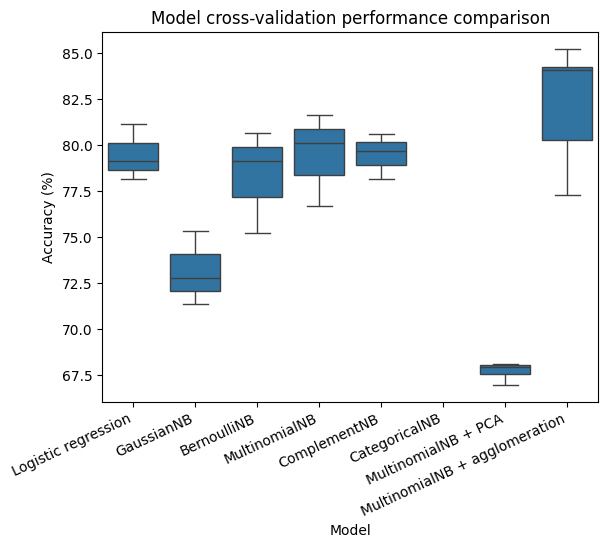

In [42]:
sns.boxplot(pd.DataFrame.from_dict(cross_val_scores), x='Model', y='Score')
plt.title('Model cross-validation performance comparison')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=25, ha='right')
plt.show()

## 7. Final model evaluation

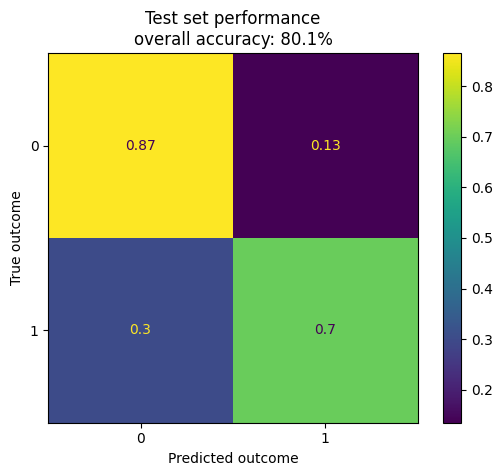

In [36]:
model = MultinomialNB()
model.fit(training_df.drop('polarity', axis=1), training_df['polarity'])

testing_predictions = model.predict(testing_df.drop('polarity', axis=1))
accuracy = accuracy_score(testing_predictions, testing_df['polarity'])*100

# Plot the confusion matrix
cm = confusion_matrix(testing_df['polarity'], testing_predictions, normalize='true')
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm)
_ = cm_disp.plot()

plt.title(f'Test set performance\noverall accuracy: {accuracy:.1f}%')
plt.xlabel('Predicted outcome')
plt.ylabel('True outcome')
plt.show()